In [7]:
#Importing necessary libraries 
import keras
import numpy as np
import pandas as pd
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

In [8]:
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))

In [9]:
# Checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe00b6ead30> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe00b6954e0> True
<keras.layers.convolutional.Conv2D object at 0x7fe00b695278> True
<keras.layers.normalization.BatchNormalization object at 0x7fe0080daef0> True
<keras.layers.core.Activation object at 0x7fdff2458518> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fdffb56e898> True
<keras.layers.pooling.MaxPooling2D object at 0x7fdff243c588> True
<keras.layers.convolutional.Conv2D object at 0x7fdff2460fd0> True
<keras.layers.normalization.BatchNormalization object at 0x7fe0116e9da0> True
<keras.layers.core.Activation object at 0x7fe0116e9f60> True
<keras.layers.convolutional.Conv2D object at 0x7fe01170b6a0> True
<keras.layers.normalization.BatchNormalization object at 0x7fe011668198> True
<keras.layers.core.Activation object at 0x7fe0116685f8> True
<keras.layers.convolutional.Conv2D object at 0x7fe011609c50> True
<keras.layers.convolutional.Conv2D obj

In [13]:
# Adding classifier on top of Convolutional base
# create the model
model = models.Sequential()

# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Showing summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 3075      
Total params: 31,980,419
Trainable params: 31,927,299
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(  
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True)


# Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# path to dataset
os.chdir('/home/sachin_sharma/Desktop/exp_2_jpg')

# This will create 80:20 split of training and test set 
training_set = train_datagen.flow_from_directory(
        'TrainingSet',
         target_size=(64,64),
         batch_size=32,
         class_mode='categorical')

# This will create the Test set
test_set = test_datagen.flow_from_directory(
        'TestSet',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical', 
        shuffle=False)

Found 22528 images belonging to 3 classes.
Found 6460 images belonging to 3 classes.


In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
          training_set, 
          steps_per_epoch=(training_set.samples/32),
          epochs=10,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))

Epoch 1/10
704/704 [==============================] - 56s 79ms/step - loss: 1.0128 - acc: 0.8219 - val_loss: 0.5899 - val_acc: 0.8604
Epoch 2/10
704/704 [==============================] - 45s 64ms/step - loss: 0.4079 - acc: 0.8765 - val_loss: 0.3344 - val_acc: 0.8850
Epoch 3/10
704/704 [==============================] - 45s 65ms/step - loss: 0.3750 - acc: 0.8903 - val_loss: 0.6412 - val_acc: 0.8255
Epoch 4/10
704/704 [==============================] - 46s 65ms/step - loss: 0.3740 - acc: 0.9007 - val_loss: 0.2498 - val_acc: 0.8935
Epoch 5/10
704/704 [==============================] - 46s 65ms/step - loss: 0.3809 - acc: 0.9014 - val_loss: 0.4355 - val_acc: 0.8406
Epoch 6/10
704/704 [==============================] - 46s 65ms/step - loss: 0.1961 - acc: 0.9098 - val_loss: 0.2062 - val_acc: 0.8964
Epoch 7/10
704/704 [==============================] - 47s 66ms/step - loss: 0.1947 - acc: 0.9138 - val_loss: 0.2454 - val_acc: 0.8896
Epoch 8/10
704/704 [==============================] - 46s 65ms

In [16]:
model.save('exp2_a1.1.h5')

In [17]:
# Visualizing the mapping between labels
training_set.class_indices


{'Else': 0, 'Industrial': 1, 'Residential': 2}

In [18]:
# Confusion Matrix 
Y_pred = model.predict_generator(test_set, test_set.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1) # predictions
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
#print(cm)
# visualizing results in table
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["Else", "Industrial", "Residential"])
print(df)

Confusion Matrix
             Else  Industrial  Residential
Else         4496          59          245
Industrial      2         372          386
Residential     6          44          850


In [19]:
# Classification report
print('Classification Report')
target_names = ['Else','Industrial','Residential']
classificn_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(classificn_report)

Classification Report
              precision    recall  f1-score   support

        Else       1.00      0.94      0.97      4800
  Industrial       0.78      0.49      0.60       760
 Residential       0.57      0.94      0.71       900

   micro avg       0.89      0.89      0.89      6460
   macro avg       0.79      0.79      0.76      6460
weighted avg       0.91      0.89      0.89      6460



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


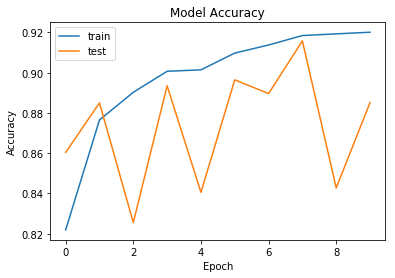

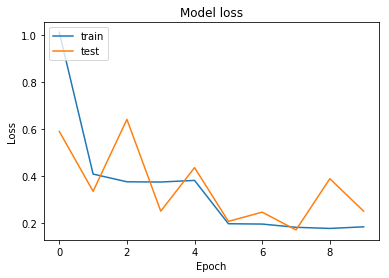

In [20]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
